In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torch
from scipy.interpolate import make_interp_spline, make_smoothing_spline, UnivariateSpline
from scipy.stats import pearsonr
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams, rc
import spikeinterface.qualitymetrics as sqm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
import phate
import bisect
from kneed import KneeLocator
import math

In [36]:
# import data
version = 24
scratch = f'/home/lss72/palmer_scratch/spike_sort'
marques_smith = '/home/lss72/TempoSort/data/2018_Marques-Smith'
filename = f"{scratch}/c{version}/c{version}_npx_raw.bin"
patch_filename = f"{scratch}/c{version}/c{version}_patch_ch1.bin"

# filename = f"{scratch}/c24/c24_npx_raw.bin"
# patch_filename = f"{scratch}/c24/c24_patch_ch1.bin"

npx_channels = 384

Sampling_frequency = 30_000  #Hz
Probe_numChannels = 384
Probe_dtype = np.uint16
# Probe_voltage_step_size = 0.195e-6
# Probe_y_digitization = 32768
# Juxta_numChannels = 8
# Juxta_dtype = np.uint16
# Juxta_ADC_used_channel = 0
# Juxta_Gain = 100
# Juxta_y_digitization = 65536
# Juxta_y_range=10
# distance_min = 31
Probe_closest_electrode = 218
# Probe_closest_electrode = 109

# helper functions
### The code below has been adapted from:
# https://github.com/kampff-lab/sc.io/blob/master/Paired%20Recordings/Preprint%20Code/1_Filtering%2C%20CAR%2C%20patch%20spike%20detection%20and%20STA%20npx%20arrays.py

def find_peaks(wcrecording, T):
    ''' T used to set threshold'''

    juxta_threshold = T*np.std(wcrecording)
    ThreshSub = wcrecording - juxta_threshold
    ThreshCrosses = np.diff(np.sign(ThreshSub))
    SpikeWstart = []
    SpikeWend = []
    SpikeWstart.append(np.where(ThreshCrosses == 2))
    SpikeWend.append(np.where(ThreshCrosses == -2))

    SpikeWDurs = [SpikeWend[0][0][i] - SpikeWstart[0][0][i] for i in range(len(SpikeWstart[0][0]))]
    
    duration_rejects = [index for index in range(len(SpikeWDurs)) if SpikeWDurs[index] < 5]
    
    a = SpikeWstart[0][0]
    b = SpikeWend[0][0]
    
    FinalWstart = [a[item] for item in range(len(a)) if item not in duration_rejects]
    FinalWend = [b[item] for item in range(len(b)) if item not in duration_rejects]
    
    FinalWDurs = [FinalWend[i] - FinalWstart[i] for i in range(len(FinalWstart))]

    
    wc_spike_samples = [list() for x in range(len(FinalWstart))]
    
    for i in range(len(wc_spike_samples)):
        wc_spike_samples[i].append( (FinalWstart[i] + np.argmax(wcrecording [FinalWstart[i] : FinalWend[i]])))
    wc_spike_samples = np.concatenate(wc_spike_samples)
        
    return wc_spike_samples, juxta_threshold

def split_list_pairwise(l,p):
    groups = []
    prev = None
    group = None
    for x in l:
        if prev is None or p(x,prev):
            group = []
            groups.append(group)
        group.append(x)
        prev = x
    return groups

def custom_find_peaks(data_raw_spikes, sampling_freq, scaling_factor):

    inter_spike_time_distance = sampling_freq // 1000
    # threshold = 7*np.std(data_raw_spikes)
    threshold = 0.8e-3

    # scaling_factor = amp_y_range / (amp_y_digitization * amp_gain)
    data_in_v = (data_raw_spikes - np.mean(data_raw_spikes)) * scaling_factor

    derivative = np.diff(np.sign(np.diff(data_in_v))) #check when deriv changes sign
    if threshold > 0:
        derivative = derivative < 0
    else:
        derivative = derivative > 0

    peaks = np.flatnonzero(derivative) + 1  # local max
    if threshold > 0:
        peaks = peaks[data_in_v[peaks] > threshold]
    else:
        peaks = peaks[data_in_v[peaks] < threshold]

    if inter_spike_time_distance > 0:
        gpeaks = split_list_pairwise(peaks, lambda x, p: x - p > inter_spike_time_distance)
        peaks = np.array([g[np.argmax([data_in_v[i] for i in g])] for g in gpeaks])
    return peaks, data_in_v


# Load data from bin files into a matrix of n channels x m samples 
def loadExtraRawData(filename):
    
    npx_recording = np.memmap(filename, mode = 'r', dtype=np.int16, order = 'C')
    npx_samples = int(len(npx_recording)/npx_channels)
    npx_recording = npx_recording.reshape((npx_channels, npx_samples), order = 'F')
    print((npx_channels, npx_samples))
    # mult by 2.34375 to get microV
    
    return npx_recording


def loadPatchRawData(patch_path, npx_recording):
    patch_recording = np.fromfile(patch_path, dtype='float64')
    return patch_recording

# loading extra data
# extra = loadExtraRawData(filename)
# extra_Volts = extra * 2.34375

# loading juxta data
juxta = loadPatchRawData(patch_filename, extra_Volts)
# spike_triggers, spike_data_in_V = custom_find_peaks(juxta, 50023.88170476, 2.34375)
juxta_filt = juxta - np.mean(juxta)

# getting filtered juxta
from scipy.signal import butter, filtfilt
from torch.fft import fft, ifft, fftshift

def get_highpass_filter(fs=30000, cutoff=300, device=torch.device('cuda')):
    """Filter to use for high-pass filtering."""
    NT = 30122
    
    # a butterworth filter is specified in scipy
    b,a = butter(3, cutoff, fs=fs, btype='high')

    # a signal with a single entry is used to compute the impulse response
    x = np.zeros(NT)
    x[NT//2] = 1

    # symmetric filter from scipy
    hp_filter = filtfilt(b, a , x).copy()
    
    hp_filter = torch.from_numpy(hp_filter).to(device).float()
    return hp_filter

def fft_highpass(hp_filter, NT=30122, device=torch.device('cuda')):
    """Convert filter to fourier domain."""
#     device = hp_filter.device
    ft = hp_filter.shape[0]

    # the filter is padded or cropped depending on the size of NT
    if ft < NT:
        pad = (NT - ft) // 2
        fhp = fft(torch.cat((torch.zeros(pad).to(device), 
                             hp_filter,
                             torch.zeros(pad + (NT-pad*2-ft)).to(device))))
    elif ft > NT:
        crop = (ft - NT) // 2 
        fhp = fft(hp_filter[crop : crop + NT])
    else:
        fhp = fft(hp_filter)
    return fhp


sample_rate = 50023.88170476

Fcutoff = 200
Fsampling = 30000

Wn = np.float32(Fcutoff / (Fsampling / 2.0))
filterOrder = 6
#
b, a = butter(filterOrder, Wn, btype='highpass', analog=0, output='ba')

juxta_filt1 = np.zeros(juxta.shape)
# data_array_old = extra_Volts

# for chan in tqdm(range(len(data_array))):
#     data_array[chan,:] = filtfilt(b, a, data_array_old[chan,:])

# filter raw data -- do it one channel at a time due to memory constraints
hp_filter = get_highpass_filter(sample_rate)
X = torch.from_numpy(juxta).to(torch.device('cuda'))

# apply filter in Fourier space
fwav = fft_highpass(hp_filter, NT=1)
X = torch.real(ifft(fft(X) * torch.conj(fwav)))
X = fftshift(X, dim = -1)

juxta_filt1 = np.array(X.cpu()) #grab the single row from X corresponding to chan 

spike_data_in_V = juxta_filt1
spike_triggers, thresh = find_peaks(juxta_filt1, 7)

m = len(juxta_filt)/float(len(extra_Volts[0])) # finding scale factor
num_of_spikes = len(spike_triggers)

In [44]:
filtered_data_type = np.uint16
num_of_points_in_spike_trig_ivm = 128
num_of_points_for_padding = num_of_points_in_spike_trig_ivm//2

#Filter for extracellular recording
def highpass(data,BUTTER_ORDER=3, F_HIGH=14250,sampleFreq=Sampling_frequency,passFreq=100.0):
    b, a = signal.butter(BUTTER_ORDER,(passFreq/(sampleFreq/2.), F_HIGH/(sampleFreq/2.)),'pass')
    return signal.filtfilt(b,a,data)

shape_spike_data = (num_of_spikes, Probe_numChannels, num_of_points_in_spike_trig_ivm)
ivm_data_filtered = np.zeros(shape_spike_data, dtype=filtered_data_type)
ivm_data_unfiltered = np.zeros(shape_spike_data, dtype=extra_Volts.dtype)

for spike_i in range(num_of_spikes):
    if (spike_i + 1) % 25 == 0:
        print(spike_i +1, end=' ', flush=True)

    trigger_point = spike_triggers[spike_i]
    start_point = int(trigger_point - (num_of_points_in_spike_trig_ivm + num_of_points_for_padding))
    assert start_point >= 0
    end_point = int(trigger_point + (num_of_points_in_spike_trig_ivm + num_of_points_for_padding))
    if end_point > extra.shape[1]:
        break
        
    temp_unfiltered = extra_Volts[:, start_point:end_point].astype(filtered_data_type)
    ivm_data_unfiltered[spike_i] = temp_unfiltered[:, num_of_points_in_spike_trig_ivm:-num_of_points_in_spike_trig_ivm]
    temp_filtered = highpass(temp_unfiltered)
    temp_filtered = temp_filtered[:, num_of_points_in_spike_trig_ivm:-num_of_points_in_spike_trig_ivm]
    ivm_data_filtered[spike_i] = temp_filtered
print()

25 50 75 100 125 150 175 200 225 


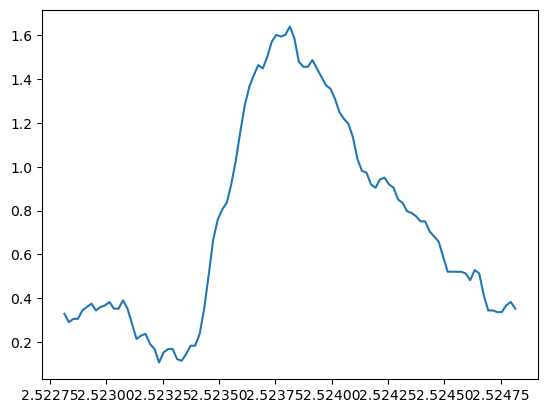

In [38]:
Sampling_frequency = 50023.88170476
peak_i = 2
window_half_size = 50 #1 ms = 30
ix = spike_triggers[peak_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size + 1)
plt.plot(window_ixs / Sampling_frequency, spike_data_in_V[window_ixs])

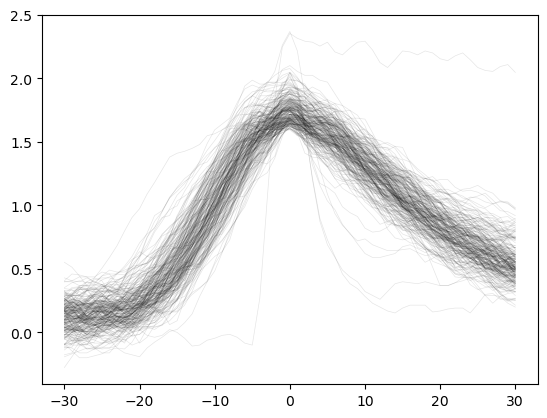

In [40]:
import matplotlib.pyplot as plt
window_half_size = 30 #1 ms = 30
for peak_i in range(len(spike_triggers)):
    
    ix = spike_triggers[peak_i]
    window_ixs = np.arange(ix - window_half_size, ix + window_half_size + 1)
    plt.plot(range(-window_half_size,window_half_size+1), spike_data_in_V[window_ixs], lw=0.5, c='k', alpha=0.1)
    
plt.show()

filtered extracellular data


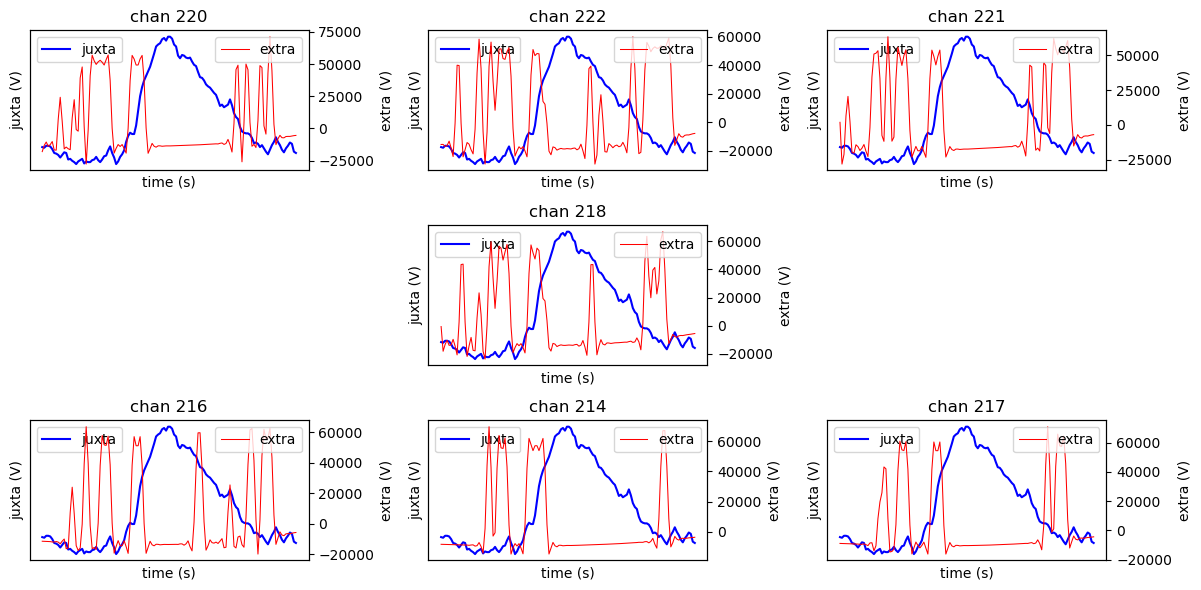

In [47]:
nearby_chans = [220, 222, 221, 0, 218, 0, 216, 214, 217]

spike_i = 1

ncols = 3
nrows = 3
f, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*2))


window_half_size = num_of_points_in_spike_trig_ivm//2 #1 ms = 30
ix = spike_triggers[spike_i]
window_ixs = np.arange(ix - window_half_size, ix + window_half_size +  int(window_half_size % 2 == 1))


for index, chan_i in enumerate(nearby_chans):
    ax_juxta = axes.ravel()[index]
    
    if chan_i == 0: 
        ax_juxta.axis('off')
        continue
        
    ax_extra = ax_juxta.twinx()
    ax_juxta.plot(window_ixs / Sampling_frequency, spike_data_in_V[window_ixs], c='b', label='juxta')
    ax_extra.plot(window_ixs / Sampling_frequency, highpass(ivm_data_filtered[spike_i,chan_i]), c='r', lw=0.75, label='extra')
    ax_juxta.set(xticks=[], yticks=[], title=f'chan {chan_i}')
    ax_juxta.set(xlabel='time (s)', ylabel='juxta (V)')
    ax_extra.set(xlabel='time (s)', ylabel='extra (V)')
    ax_juxta.tick_params(axis='x',labelsize=8)
    ax_juxta.legend(loc='upper left')
    ax_extra.legend(loc='upper right')
        
f.tight_layout()
print('filtered extracellular data')
plt.show()